## Modely na spracovanie signálov z vibrácií

Modely na monitorovanie vibrácií na základe analyzovaných algoritmov. Meranie úspešnosti na synteticky generovaných dátach.

### Toky v návrhu riešenia
1. Frekvenčná analýza
2. Online štatistiky v čase + Identifikácia náhlych zmien
3. Kinematická analýza
4. Podvzorkovanie


#### Algoritmy na rozpoznávanie špičiek
za aplikovania vyhladzovania cez priemerovací filter

0. Detekcia špičiek prahovou úrovňou
1. Význačnosť vrchola spomedzi susedov
2. Algoritmus prechodu nulou do záporu
3. Algoritmus horského turistu

#### Štatistiky v časovej doméne (Rozpínajúce vs. Posuvné okno)
- Amplitúda špička-špička
- Kvadratický priemer (RMS)
- Výberový priemer
- Medián, Horný a dolný kvartil
- Výberový rozptyl  (Welfordov algoritmus)
- Smerodajná odchýlka
- Priemerná absolútna odchýlka 
- Mediánová absolútna odchýlka 
- Medzikvartilové rozpätie
- Korelácia

#### Rozklad vo frekvenčnej doméne
- Fouriérová transformácia - FFT
- DCT-II, DCT-IV, MDCT
- Oknové funkcie: obdĺžníkové, Bartlettovo, Hannovo, Hammingovo a Blackmanovo okno
- Welchova metóda

#### Numerická integrácia pre získanie rýchlosti a polohy
- Obdlžnikové, Lichobežníkovo, Simsonovo pravidlo na úsekoch
- Korekcia obálkami: B-spline / Amplitúdová obálka (ako mean filter)

In [1]:
import numpy as np
from scipy.signal.windows import boxcar, bartlett, hann, hamming, blackman
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from typing import Tuple
import json
from functools import partial

TimeSeries = Tuple[np.array, np.array]

### Detekcia špičiek prahovou úrovňou
- `y`: postupnosť vzoriek
- `t`: prahová úroveň. Rozsah: $[0, \max{\{y\}}]$

In [2]:
def find_peaks_threshold(y: np.array, t: float):
    return np.where(y >= t)

### Význačnosť vrchola spomedzi susedov
- `y`: postupnosť vzoriek
- `k`: počet najbližších uvažovaných susedov na každú zo strán od vrchola $[i-k; i+k]$. Rozsah: $[1, \mathrm{length}(y)\,/\, 2]$
- `e`: relatívna tolerancia vyššieho bodu v susedstve od vrchola. Rozsah: $[0, \max{\{y\}}]$
- `h_rel`: relatívna výška vrcholu v susedstve. Rozsah: $[0, \max{\{y\}}]$
- `h`: Absolútna amplitúda. Rozsah: $[0, \max{\{y\}}]$

In [3]:
def find_peaks_neighbours(y: np.array, k: int, e: float, h_rel: float, h: float) -> list:
    peaks = []
    for i in range(len(y)):
        if abs(y[i]) >= h:
            possible_peak = True
            a = max(i - k, 0)
            b = min(i + k, len(y))
            valley = y[a]

            for j in range(a, b):
                if i != j:
                    if y[j] - y[i] > e:
                        possible_peak = False
                    if y[j] < valley:
                        valley = y[j]

            if possible_peak is True and y[i] - valley > h_rel:
                peaks.append(i)
    return peaks

### Algoritmus prechodu nulou do záporu
- `y`: postupnosť vzoriek
- `k`: dlžka sečnice $[i-k; i+k]$. Rozsah: $[1, \mathrm{length}(y)\,/\, 2]$
- `slope`: prahová strmosť kopca. $slope >= 0$

In [4]:
def find_peaks_zero_crossing(y: np.array, k: int, slope: float) -> list:
    peaks = []

    for i in range(k, len(y) - k):
        if ((y[i + k] - y[i]) < 0 and (y[i] - y[i - k]) > 0 and
                abs(y[i + k] - y[i]) >= slope and abs(y[i] - y[i - k]) >= slope):
            peaks.append(i)

    return peaks

### Algoritmus horského turistu
- `y`: postupnosť vzoriek
- `tolerance`: prahová úroveň vo vertikálnej osi. Rozsah: $[0, \max{\{y\}}]$
- `hole`: prahová úroveň v horizontálnej osi. Rozsah: $[0, \mathrm{length}(y)]$
- `prominence`: relatívna výška oproti predošlej navštívenej doline. Rozsah: $[0, \max{\{y\}}]$
- `isolation`: vzdialenosť k najbližšiemu skoršiemu vrcholu. Rozsah: $[0, \mathrm{length}(y)]$

In [5]:
def find_peaks_hill_walker(
        y: np.array, tolerance: float, hole: float, prominence: float, isolation: float) -> list:
    peaks = []
    i_change = 0
    y_valley = 0
    possible_change = False
    uphill = bool((y[1] - y[0]) >= 0)
    
    for i in range(1, len(y)):
        y_step = y[i] - y[i - 1]
        slope = bool(y_step >= 0)

        if possible_change is False and uphill != slope:
            possible_change = True
            i_change = i - 1
        elif possible_change is True and uphill == slope:
            possible_change = False
        
        if (possible_change is True and
                uphill != slope and
                abs(i - i_change) > hole and
                abs(y[i] - y[i_change]) > tolerance):
            
            possible_change = False
            prev_uphill = uphill
            uphill = slope

            if prev_uphill is False and uphill is True:
                y_valley = y[i_change]

            elif (prev_uphill is True and 
                      uphill is False and 
                      abs(y[i - hole] - y_valley) > prominence):
                if len(peaks) < 1 or (len(peaks) >= 1 and i_change - peaks[-1] > isolation):
                    y_peak = y[i_change]
                    peaks.append(i_change)
                  
    return peaks

### Generovanie sínusoidy
s frekvenciou, trvaním, pri vzorkovacej frekvencii

In [6]:
def sine_generate(f: int, t: float, fs: int) -> TimeSeries:
    N = fs * t                                         # počet vzoriek
    Ts = 1 / fs                                        # interval vzorkovania
    t_series = Ts * np.arange(N)
    return t_series, np.sin(2 * np.pi * f * t_series)  # y = A * sin(2*pi*t)

def plot_sinusoid(x, y, p, ax):
    ax.plot(x, y)
    if len(p) > 0: 
        ax.plot(x[p], y[p], 'o', color='r')
    ax.grid()

find_peaks_neighbours:	 [5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 199]
find_peaks_zero_crossing: [5, 25, 45, 65, 85, 105, 125, 145, 165, 185]
find_peaks_hill_walker:	 [5, 25, 45, 65, 85, 105, 125, 145, 165, 185]


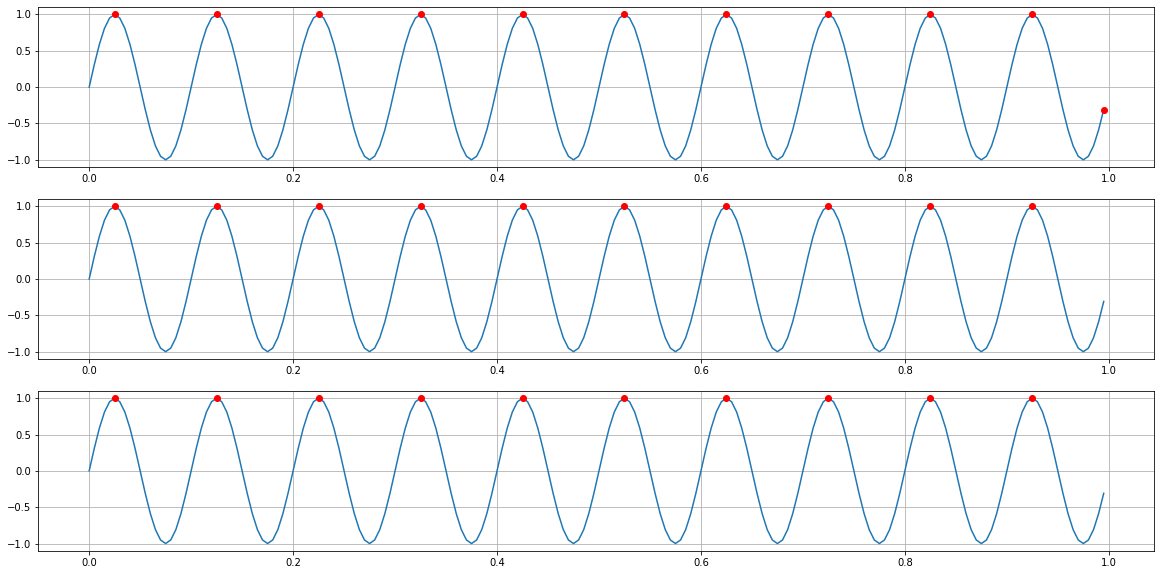

In [7]:
x, y = sine_generate(10, 1, 200)
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

p = find_peaks_neighbours(y, k=2, e=0, h_rel=0, h=0)
print('find_peaks_neighbours:\t', p)
plot_sinusoid(x, y, p, axes[0])

p = find_peaks_zero_crossing(y, k=1, slope=0)
print('find_peaks_zero_crossing:', p)
plot_sinusoid(x, y, p, axes[1])

p = find_peaks_hill_walker(y, tolerance=0, hole=0, prominence=0, isolation=0)
print('find_peaks_hill_walker:\t', p)
plot_sinusoid(x, y, p, axes[2])

### Oknovanie (1) a transformácia do frekvenčnej domény (2)
- `y`: postupnosť vzoriek
- `t`: časové značky v sekundách pre jednotlivé vzorky
- `window`: oknová funkcia. Rozsah: boxcar, bartlett, hann, hamming, blackman
- `Wn`: dĺžka posuvného okna v počte vzoriek. Rozsah: $[1, \mathrm{length}(y)]$
- `overlap`: pomer prelínania posuvných okien. Rozsah: $[0, 0.99]$
- `fs`: vzorkovacia frekvencia v Hz
- `mode`: spôsob transformácie magnitúdového spektra (linear vs. log)

In [8]:
def fft_transform(v):
    elements = np.fft.fft(v)
    return np.absolute(elements)[:len(elements)//2]


def fft_log_transform(v):
    elements = np.fft.fft(v)
    yf = np.absolute(elements)[:len(elements)//2]
    return 20 * np.log10(yf / yf.max())


def frequency_spectrum(t: np.array, y: np.array, fs: int, window, Wn: int, overlap: float, mode='linear'):
    step = Wn - int(Wn * overlap)
    Wi = np.arange(0, len(y) - Wn, step)
    transform = fft_log_transform if mode == 'log' else fft_transform
    
    x = t[Wi]
    f = np.fft.fftfreq(Wn, 1/fs)[:Wn//2]
    f_mag = np.asarray([transform(y[i:i+Wn] * window(Wn)) for i in Wi])
     
    return {
        'fs': fs,
        'Wn': Wn,
        'overlap': overlap,
        'resolution': fs / Wn,
        'bins': f,
        't_windows': x,
        'magnitudes': f_mag
    }

### Hľadanie špičiek v každom posuvnom okne

In [9]:
def peaks_indices_windowed(peak_find, magnitudes):
    return [peak_find(window) for window in magnitudes]

def peak_freqs_windowed(i_peaks, bins, resolution):
    return [list(zip(bins[p], bins[p] + resolution)) for p in i_peaks] 

### Vykreslenie grafu spektrálnej magnitúdy pre posuvné okná zvlášť

In [10]:
def plot_spectra_slices(bins, magnitudes, peaks=[]):
    fig, axes = plt.subplots(len(magnitudes), 1, figsize=(20, 10))
    for i, amp in enumerate(magnitudes):
        p = peaks[i] if len(peaks) > i else []
        plot_sinusoid(bins, amp, p, axes[i])
        # axes[i].set_xlim(-5, 5)

### Prepočet poradia frekvenčného vedierka na frekvencie v Hz pre skutočné a predikované špičky

In [11]:
def found_peak_freqs(truth, peaks, spectrum):
    f_truth = peak_freqs_windowed(truth, spectrum['bins'], spectrum['resolution'])
    f_peaks = peak_freqs_windowed(peaks, spectrum['bins'], spectrum['resolution'])

    for t_win, p_win in zip(f_truth, f_peaks):
        print("Okno:")
        print('\tI:', ', '.join([f'<{a:.2f}-{b:.2f}>' for a, b in t_win]))
        print('\tO:', ', '.join([f'<{a:.2f}-{b:.2f}>' for a, b in p_win]))  

### Metriky pre binárny klasifikátor pre okná zvlášť, s mikro a makro priemerovaním

In [12]:
def ground_truth(rules, windows, resolution):
    labels = []
    for start in windows:
        freqs = []
        for sine in rules.get('sines', []):
            if (sine['t0'] <= start <= sine['tn'] or 
                    sine['t0'] <= start + spectrum['Wn'] <= sine['tn']):
                freqs.append(int(sine['freq'] / resolution))
        labels.append(freqs)
    return labels

def metrics(bins, y_truth, y_predict):
    stats = []

    for win_truth, win_predict in zip(y_truth, y_predict):
        truth = np.full(len(bins), False)
        predict = np.full(len(bins), False)
        
        truth[win_truth] = True
        predict[win_predict] = True
        
        tp = sum([int(x and y) for x, y in zip(truth, predict)])
        tn = sum([int(not x and not y) for x, y in zip(truth, predict)])
        fp = sum([int(not x and y) for x, y in zip(truth, predict)])
        fn = sum([int(x and not y) for x, y in zip(truth, predict)])
        
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        ppv = 0
        if tp + fp != 0:
            ppv = tp / (tp + fp)
        acc = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn)
            
        stats.append({
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, 
            'TPR': tpr, 'TNR': tnr,  'PPV': ppv,
            'ACC': acc, 'FPR': fpr
        })

    return stats

def metric_macro_average(metrics):
    averages = {
        'TPR': 0, 'TNR': 0,  'PPV': 0, 'ACC': 0, 'FPR': 0
    }
    for win_metrics in metrics:
        for k in averages.keys():
            averages[k] += win_metrics[k]
        
    for k in averages.keys():
        averages[k] /= len(metrics)
        
    return averages


def metric_micro_average(metrics):
    averages = {
        'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 
    }
    for win_metrics in metrics:
        for k in averages.keys():
            averages[k] += win_metrics[k]

    tp, tn, fp, fn = (
        averages['TP'], averages['TN'], averages['FP'], averages['FN']
    )
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    ppv = 0
    if tp + fp != 0:
        ppv = tp / (tp + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn)
    
    return {
        'TPR': tpr, 'TNR': tnr, 'PPV': ppv,
        'ACC': acc, 'FPR': fpr
    }

### Generovanie sinusoidy s f = 15 Hz, trvaním t = 1s pri fs = 250Hz

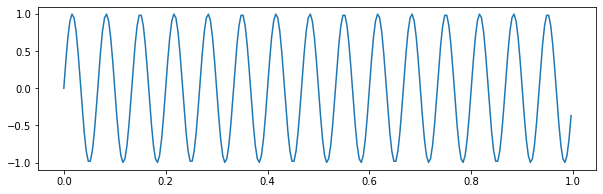

In [13]:
plt.rcParams['figure.figsize'] = (10, 3)
rec = {
    'duration': 1,
    'f_sampling': 250,
    'sines': [{'freq': 15, 'amp': 1, 't0': 0, 'tn': 1}],
}
t, y = sine_generate(f=rec['sines'][0]['freq'], t=rec['duration'], fs=rec['f_sampling'])
plt.plot(t, y)
plt.show()

### Hľadanie špičiek spomedzi najbližších susedov vo frekvenčnej doméne na sínusoide s f = 20 Hz

Okno:
	I: <11.90-15.87>
	O: <15.87-19.84>
Okno:
	I: <11.90-15.87>
	O: <15.87-19.84>
Okno:
	I: <11.90-15.87>
	O: <15.87-19.84>


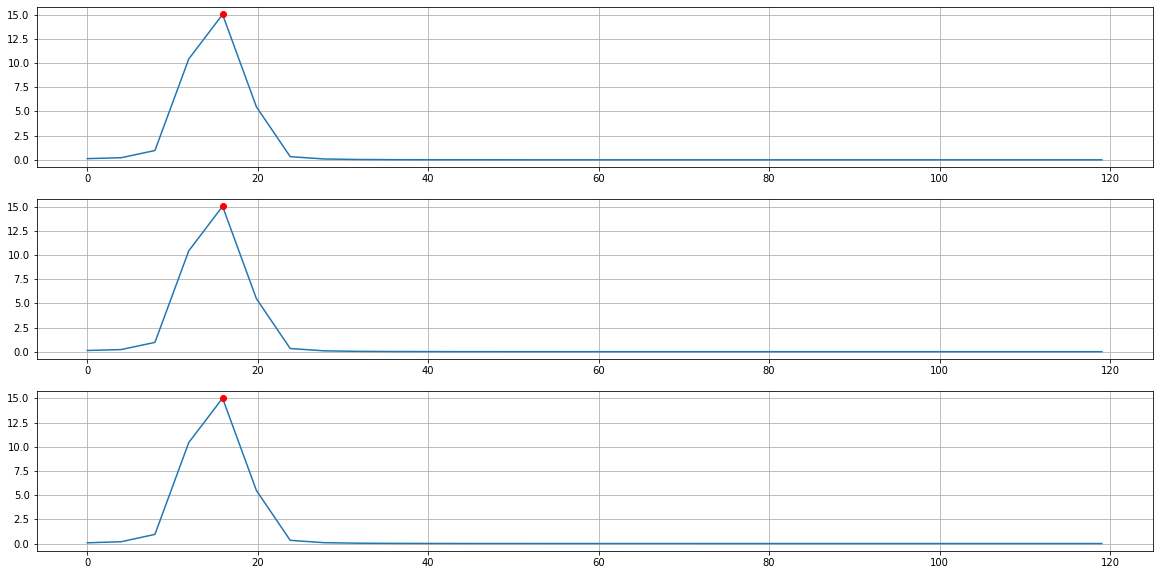

In [14]:
spectrum = frequency_spectrum(t, y, fs=rec['f_sampling'], window=hann, Wn=63, overlap=0, mode='linear')
func = partial(find_peaks_neighbours, k=3, e=0, h_rel=0, h=0)

peaks = peaks_indices_windowed(func, spectrum['magnitudes'])
plot_spectra_slices(spectrum['bins'], spectrum['magnitudes'], peaks)

truth = ground_truth(rec, spectrum['t_windows'], spectrum['resolution'])
found_peak_freqs(truth, peaks, spectrum)

### Vyhodnotenie klasifikácie špičiek

In [15]:
m = metrics(spectrum['bins'], truth, peaks)
from pprint import pprint
print('Podľa okna:')
pprint(m)
print('Makro:', metric_macro_average(m))
print('Mikro:', metric_micro_average(m))

Podľa okna:
[{'ACC': 0.9354838709677419,
  'FN': 1,
  'FP': 1,
  'FPR': 0.03333333333333333,
  'PPV': 0.0,
  'TN': 29,
  'TNR': 0.9666666666666667,
  'TP': 0,
  'TPR': 0.0},
 {'ACC': 0.9354838709677419,
  'FN': 1,
  'FP': 1,
  'FPR': 0.03333333333333333,
  'PPV': 0.0,
  'TN': 29,
  'TNR': 0.9666666666666667,
  'TP': 0,
  'TPR': 0.0},
 {'ACC': 0.9354838709677419,
  'FN': 1,
  'FP': 1,
  'FPR': 0.03333333333333333,
  'PPV': 0.0,
  'TN': 29,
  'TNR': 0.9666666666666667,
  'TP': 0,
  'TPR': 0.0}]
Makro: {'TPR': 0.0, 'TNR': 0.9666666666666667, 'PPV': 0.0, 'ACC': 0.9354838709677419, 'FPR': 0.03333333333333333}
Mikro: {'TPR': 0.0, 'TNR': 0.9666666666666667, 'PPV': 0.0, 'ACC': 0.9354838709677419, 'FPR': 0.03333333333333333}


### Hľadanie špičiek spomedzi najbližších susedov vo frekvenčnej doméne 
sínusoida s f = 8 Hz, t = 4 s, fs = 100 Hz v logaritmickej mierke

Okno:
	I: <7.87-8.66>
	O: <7.87-8.66>
Okno:
	I: <7.87-8.66>
	O: <7.87-8.66>
Okno:
	I: <7.87-8.66>
	O: <7.87-8.66>


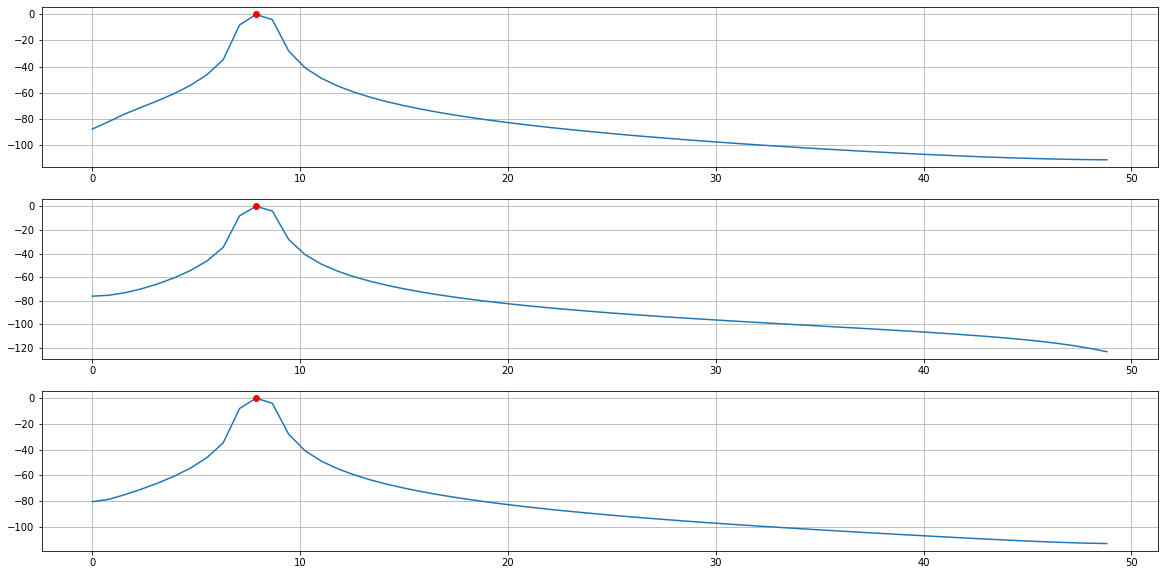

In [16]:
rec = {
    'duration': 4,
    'f_sampling': 100,
    'sines': [{'freq': 8, 'amp': 1, 't0': 0, 'tn': 4}],
}
t, y = sine_generate(f=rec['sines'][0]['freq'], t=rec['duration'], fs=rec['f_sampling'])

spectrum = frequency_spectrum(t, y, fs=rec['f_sampling'], window=hann, Wn=127, overlap=0.25, mode='log')
peaks = peaks_indices_windowed(
    peak_find=partial(find_peaks_neighbours, k=3, e=0, h_rel=0, h=0),
    magnitudes=spectrum['magnitudes']
)
plot_spectra_slices(spectrum['bins'], spectrum['magnitudes'], peaks)

truth = ground_truth(rec, spectrum['t_windows'], spectrum['resolution'])
found_peak_freqs(truth, peaks, spectrum)

### Generovanie signálu s normálne rozdeleným šumom

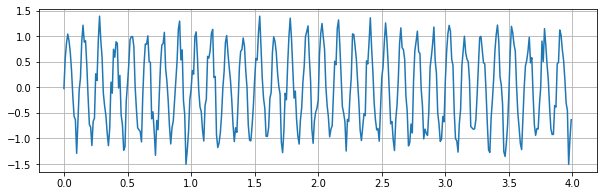

In [17]:
plt.rcParams['figure.figsize'] = (10, 3)
y_noisy = y + np.random.normal(loc=0, scale=0.2, size=len(y))
plt.plot(t, y_noisy)
plt.grid()
plt.show()

### Generátor syntetického signálu so šumom zo sinusioíd
Pravidlá na opis požadovaného signálu musia dodržať nasledujúcu štruktúru:
```json
{
    "duration": 1,
    "f_sampling": 476,
    "sines": [
        {"freq": 5, "amp": 1.5, "t0": 0, "tn": 0.5}
    ],
    "noises": [
        {"amp": 0.2, "t0": 0, "tn": 1.5}
    ]
}
```

In [18]:
def s_offsets(signal, rules):
    lower = int(signal['t0'] * rules['f_sampling'])
    upper = int((rules['duration'] - signal['tn']) * rules['f_sampling'])
    return lower, upper

def s_duration(signal, rules):
    return int(np.ceil((signal['tn'] - signal['t0']) * rules['f_sampling']))


def signal_rules(filename: str) -> dict:
    with open(filename, 'r') as fsource:
        return json.load(fsource)


def signal_generate(rules: dict) -> TimeSeries:
    N = rules['f_sampling'] * rules['duration']                                         
    Ts = 1 / rules['f_sampling']
    t_series = Ts * np.arange(N)
    signal = np.zeros(N)
    
    for sine in rules.get('sines', []):
        duration_samples = s_duration(sine, rules)
        t_part = Ts * np.arange(duration_samples)
        s = sine['amp'] * np.sin(2 * np.pi * sine['freq'] * t_part)
        signal += np.pad(s, pad_width=s_offsets(sine, rules), constant_values=0)[:len(t_series)]

    for noise in rules.get('noises', []):
        duration_samples = s_duration(noise, rules)
        s = np.random.normal(loc=0, scale=noise['amp'], size=duration_samples)
        signal += np.pad(s, pad_width=s_offsets(noise, rules), constant_values=0)[:len(t_series)]
        
    return t_series, signal


def signal_threshold(y: np.array, level: float) -> np.array:
    return np.where(abs(y) < level, 0, y)

### Vyhladzovanie signálu a oknovaného frekvenčného spektra

In [19]:
def smooth_signal(t, y, window, k: int):
    kernel = window(k) / k
    return t[k - 1:], np.convolve(y, kernel, 'valid')

def smooth_spectra(t, y, window, k: int):
    kernel = window(k) / k
    return t[k - 1:], [np.convolve(block, kernel, 'valid') for block in y]

### Vzorový syntetický signál

{'duration': 5, 'f_sampling': 476, 'sines': [{'freq': 5, 'amp': 1.5, 't0': 1, 'tn': 3.5}, {'freq': 30, 'amp': 1, 't0': 0, 'tn': 5}], 'noises': [{'amp': 0.2, 't0': 0, 'tn': 1.5}]}


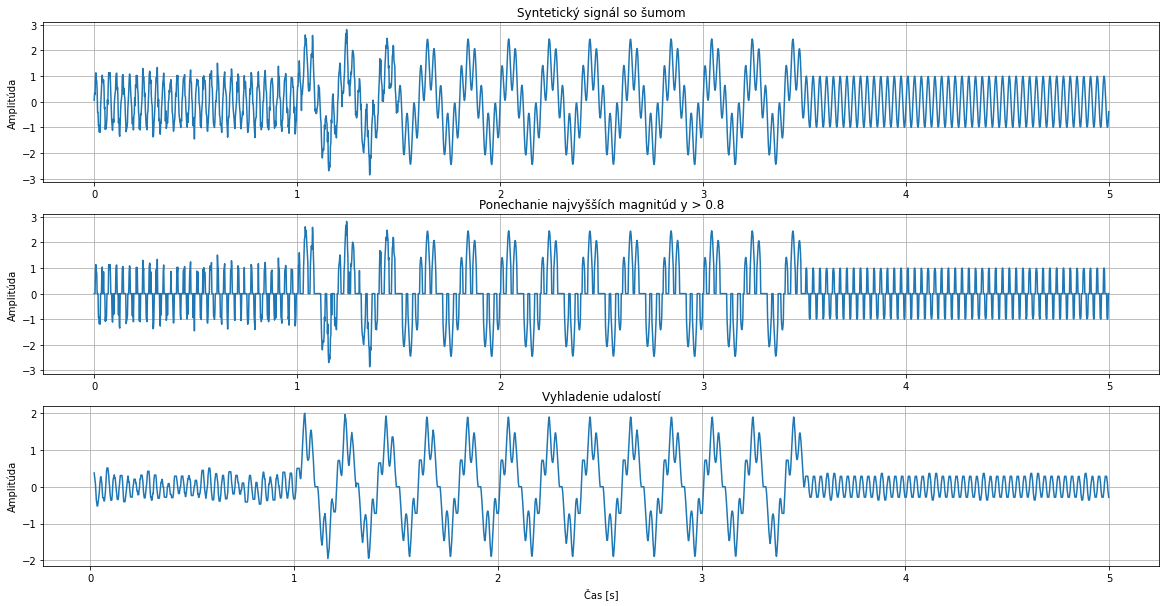

In [20]:
# Pravidlá na poskladanie tónov
recording = {
    'duration': 5,
    'f_sampling': 476,
    'sines': [
        {'freq': 5, 'amp': 1.5, 't0': 1, 'tn': 3.5},
        {'freq': 30, 'amp': 1, 't0': 0, 'tn': 5}
    ],
    'noises': [
        {'amp': 0.2, 't0': 0, 'tn': 1.5}
    ]
}
# Prípadne načítanie pravidiel zo súboru
recording = signal_rules('datasets/synth-signal/rec.json')
print(recording)

# Vzorkovaný signál podľa popisu
t, y = signal_generate(recording)
# Ponechanie vzoriek nad prahovú magnitúdu a vynulovanie ostatných
y_event = signal_threshold(y, 0.8)
# Vyhladenie signálu so zvolenou okovou funkciou a veľkosťou kernelu
t_s, y_s = smooth_signal(t, y_event, boxcar, k=10)

# Vykreslenie grafu
plt.rcParams['figure.figsize'] = (20, 10)
fig, axes = plt.subplots(3, 1)
axes[0].set_title('Syntetický signál so šumom')
axes[0].set_ylabel('Amplitúda')
axes[0].plot(t, y)
axes[0].grid()

axes[1].set_title('Ponechanie najvyšších magnitúd y > 0.8')
axes[1].plot(t, y_event)
axes[1].set_ylabel('Amplitúda')
axes[1].grid()

axes[2].set_title('Vyhladenie udalostí')
axes[2].plot(t_s, y_s)
axes[2].set_ylabel('Amplitúda')
axes[2].set_xlabel('Čas [s]')
axes[2].grid()
plt.show()

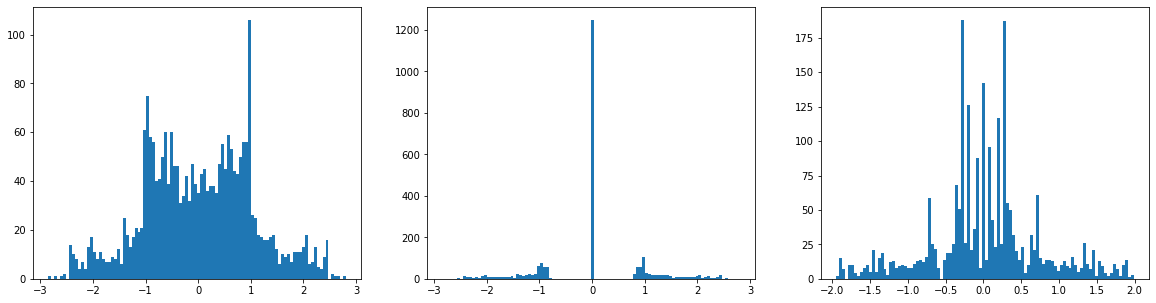

In [21]:
plt.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots(1, 3)
axes[0].hist(y, bins=100)
axes[1].hist(y_event, bins=100)
axes[2].hist(y_s, bins=100)
plt.show()

### Detekcia špičiek v signále so šumom manuálnym ladením hyperparametrov

Macro: {'TPR': 0.9375, 'TNR': 0.9980256605770128, 'PPV': 0.8125, 'ACC': 0.9975490196078431, 'FPR': 0.0019743394229871465}
Micro: {'TPR': 0.9230769230769231, 'TNR': 0.9980266403552047, 'PPV': 0.75, 'ACC': 0.9975490196078431, 'FPR': 0.001973359644795264}


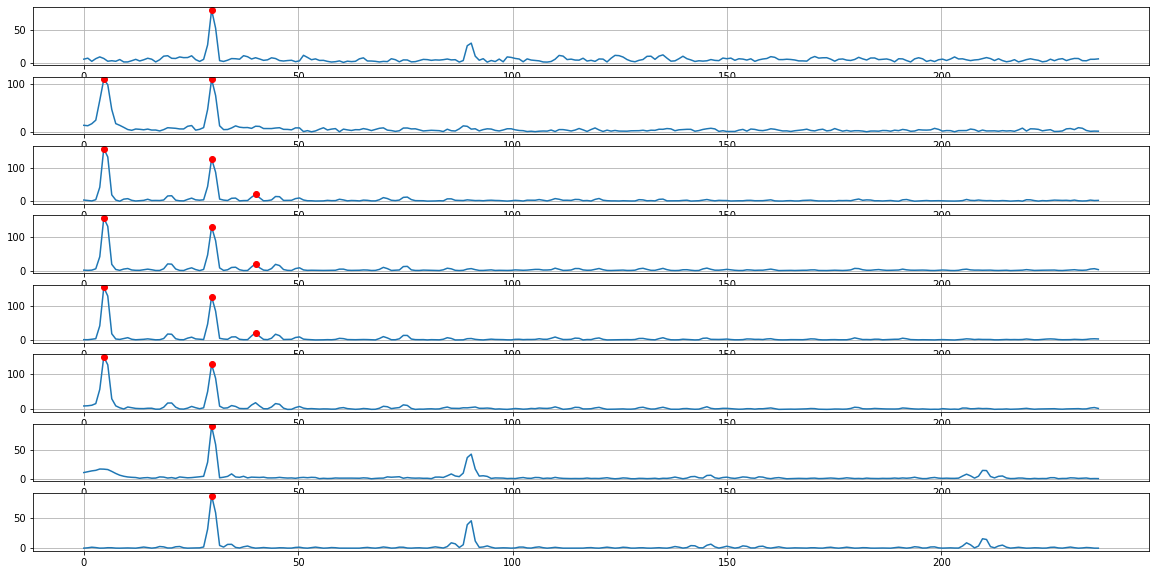

In [29]:
t, y = signal_generate(recording)
y = signal_threshold(y, 0.8) 

spectrum = frequency_spectrum(t, y, fs=recording['f_sampling'], window=hann, Wn=511, overlap=0.5, mode='linear')
#t, y = smooth_spectra(t, y, boxcar, 10)

func = partial(find_peaks_neighbours, k=20, e=0, h_rel=50, h=0)
# func = partial(find_peaks_zero_crossing, k=1, slope=8)
# func = partial(find_peaks_hill_walker, tolerance=0, hole=0, prominence=30, isolation=5)

peaks = peaks_indices_windowed(func, spectrum['magnitudes'])
plot_spectra_slices(spectrum['bins'], spectrum['magnitudes'], peaks)

truth = ground_truth(recording, spectrum['t_windows'], spectrum['resolution'])
m = metrics(spectrum['bins'], truth, peaks)

print('Macro:', metric_macro_average(m))
print('Micro:', metric_micro_average(m))

### ROC krivka

In [23]:
def grid_search(bins, truth, algorithm, *args):
    TPR = []
    FPR = []
    for params in np.array(np.meshgrid(*args)).T.reshape(-1, len(args)):
        peaks = algorithm(*params)
        m = metric_macro_average(metrics(bins, truth, peaks))
        
        TPR.append(m['TPR'])
        FPR.append(m['FPR'])
        
    TPR.sort()
    FPR.sort()
    return TPR, FPR


def roc_curve(tpr, fpr):
    plt.rcParams['figure.figsize'] = (4, 4)
    # plt.scatter(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    return auc(fpr, tpr)

In [24]:
t, y = signal_generate(recording)

spectrum = frequency_spectrum(t, y, fs=recording['f_sampling'], window=hann, Wn=255, overlap=0.5, mode='linear')
truth = ground_truth(recording, spectrum['t_windows'], spectrum['resolution'])

### ROC: význačnosť vrchola spomedzi susedov

k= [ 3  7 11 15]
e= [ 0.         11.35518802 22.71037604 34.06556406 45.42075208]
h_rel= [ 0.         18.16830083 36.33660166 54.50490249 72.67320333]


0.8629923655736804

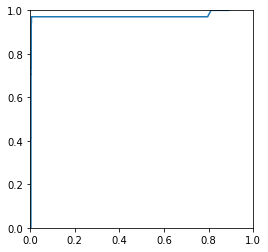

In [25]:
n = 16 #len(spectrum['bins']) // 4
K = np.arange(3, n, 4)
# Možno previesť do relatívnych čísel vzhľadom na magnitúdy v okne
E = np.linspace(0, np.max(spectrum['magnitudes']) * 0.5, 5)
H = np.linspace(0, np.max(spectrum['magnitudes']) * 0.8, 5)
print('k=', K); print('e=', E); print('h_rel=', H)

def algo_no1(k, e, h_rel):
    f = partial(find_peaks_neighbours, k=int(k), e=int(e), h_rel=h_rel, h=0)
    return peaks_indices_windowed(f, spectrum['magnitudes'])

tpr, fpr = grid_search(spectrum['bins'], truth, algo_no1, K, E, H)
roc_curve(tpr, fpr)

### ROC: algoritmus prechodu nulou do záporu

k= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
slope= [  0.          33.33333333  66.66666667 100.         133.33333333
 166.66666667 200.         233.33333333 266.66666667 300.        ]


0.05044872851101222

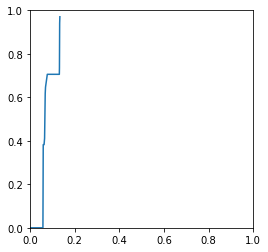

In [26]:
K = np.arange(1, 50)
S = np.linspace(0, 300, 10)
print('k=', K); print('slope=', S)

def algo_no2(k, s):
    f = partial(find_peaks_zero_crossing, k=int(k), slope=s)
    return peaks_indices_windowed(f, spectrum['magnitudes'])

tpr, fpr = grid_search(spectrum['bins'], truth, algo_no2, K, S)
roc_curve(tpr, fpr)

### ROC: algoritmus horského turistu

tolerance= [ 0.         18.16830083 36.33660166 54.50490249 72.67320333 90.84150416]
hole= [  0.   25.4  50.8  76.2 101.6 127. ]
prominence= [ 0.         18.16830083 36.33660166 54.50490249 72.67320333 90.84150416]
isolation= [  0.   25.4  50.8  76.2 101.6 127. ]


0.06372120612951064

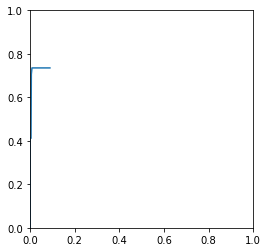

In [27]:
H = np.linspace(0, np.max(spectrum['magnitudes']), 6)
L = np.linspace(0, len(spectrum['bins']), 6)
print('tolerance=', H); print('hole=', L); print('prominence=', H); print('isolation=', L)

def algo_no3(t, h, p, i):
    f = partial(find_peaks_hill_walker, tolerance=t, hole=int(h), prominence=p, isolation=int(i))
    return peaks_indices_windowed(f, spectrum['magnitudes'])

tpr, fpr = grid_search(spectrum['bins'], truth, algo_no3, H, L, H, L)
roc_curve(tpr, fpr)

In [28]:
# načítanie reálneho samplu z vibrácií


# prerob hľadanie špičiek na vrátenie labelov -> sklearn predictory
# integračné metódy pre odvodenie rýchlosti a polohy 
# korekcia integrácie obálkami - filter vs. B-spline
# oknované štatistiky v časovej doméne a aplikácia detektorov špičiek